<IPython.core.display.Javascript object>


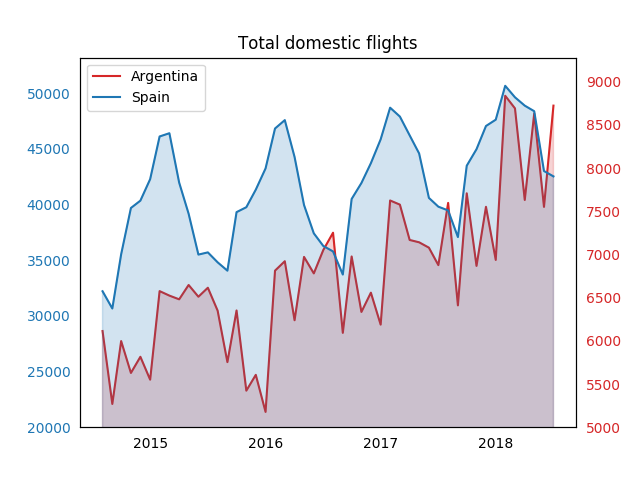

In [301]:
#http://www.aena.es/csee/Satellite?c=Page&cid=1113582476711&pagename=Estadisticas%2FEstadisticas

#https://servicios.transporte.gob.ar/gobierno_abierto/archivos/2019/eana_012014_062019.csv

import zipfile
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

%matplotlib notebook



def translate_month(m):
    d = {'Enero' : 'Jan', 'Febrero':'Feb', 'Marzo':'Mar', 'Abril':'Apr', 'Mayo': 'May','Junio':'Jun', 'Julio':'Jul', 'Agosto':'Aug', 'Septiembre':'Sep', 'Octubre':'Oct', 'Noviembre':'Nov', 'Diciembre':'Dec'}
    return d[m]

def open_eana_ar():
    df = pd.read_csv('eana_012014_062019.csv', sep=';')
    df['key'] = df['Fecha'].str[3:10]
    df = df.set_index('key')
    
    df = df[(df['Tipo de Movimiento'] == 'Despegue') & (df['Clasificación Vuelo'] == 'Cabotaje') & (df['Clase de Vuelo'] == 'Regular')]
    df = df[['Hora']]
    df = df.groupby(level=0)['Hora'].agg({'value': 'count'})

    
    df.index = pd.to_datetime(df.index)
    return df

def open_aena_es():
    df = pd.read_excel('informeEvolucion.xls', skiprows=5, usecols=range(1,12))
    # remove total row
    df = df.drop(df.index[13])
    # propagete column to first row
    for col in df.columns:
        df[col][0] = col
    #promote first row to columns        
    df.columns = df.iloc[0]   
    #drop promoted row
    df = df.drop(df.index[0])

    # extract year values 
    month_col = df.columns[0]
    year_cols = []
    for i in range(1, df.columns.size, 2):
        col_left = df.columns[i] 
        col_right =  df.columns[i+1]
        cons_col = '{}'.format(col_right)
        df[cons_col] = df[col_left]      
        year_cols.append(cons_col)
    #proyect needed columns        
    df = df[[month_col]+year_cols]
    #unpivot values to get detail
    df = pd.melt(df, id_vars=[month_col], value_vars=year_cols, var_name='date', value_name='value')
    #reformat to key/value
    df['key'] = df.apply(lambda r: '{} {}'.format(translate_month(r[month_col]),r['date']), axis=1)
    df['value']  = df.apply(lambda r: float(r['value'].replace('.','')), axis=1)
    df.set_index('key', inplace=True)
    df = df[['value']]
    df.index = pd.to_datetime(df.index)
    return df

def plot_country(ax, country, index, values, color, bottom,labelleft , labelright):
    zeros = [0 for i in range(0, index.size)]
    lines = ax.plot(values, color=color, label=country)
    ax.tick_params(axis='y', labelcolor=color, left='off', right='off',labelleft=labelleft, labelright=labelright)
    ax.fill_between(index, zeros,
                         values,
                         color=color,  alpha=0.2)
    ax.set_ylim(bottom = bottom)
    return lines[0]

eana_ar = open_eana_ar()
aena_es = open_aena_es()

both = pd.merge(eana_ar, aena_es, how='inner', left_index=True, right_index=True)
both = both.loc[pd.to_datetime('2015-01-01'):]
fig, ax1 = plt.subplots()
ax1.tick_params(bottom='off')
ax2 = ax1.twinx()

line1 = plot_country(ax1, 'Argentina', both.index, both['value_x'], 'tab:red', 5000, 'off', 'on')
line2 = plot_country(ax2, 'Spain', both.index, both['value_y'], 'tab:blue', 20000, 'on', 'off')


x = plt.gca().xaxis

plt.gca().set_xticks(list(filter(lambda i:i.month in [6], both.index)))
x.set_major_formatter(DateFormatter('%Y'))

plt.title('Total domestic flights')

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper center')


fig.legend(
    handles=(line1, line2),
    labels=('Argentina', 'Spain'),
    loc='upper left',
 bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)







